# Libraries and Data Information

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

import tensorflow as tf
from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings("ignore")

# Read and Check Data

In [ ]:
# DOM_MW --->> Dominion Virginia Power (DOM) - Megawatt Energy Consumption

df = pd.read_csv("/content/DOM_hourly(1).csv")
df.head()

,Datetime,DOM_MW
0,2005-12-31 01:00:00,9389.0
1,2005-12-31 02:00:00,9070.0
2,2005-12-31 03:00:00,9001.0
3,2005-12-31 04:00:00,9042.0
4,2005-12-31 05:00:00,9132.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116189 entries, 0 to 116188
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  116189 non-null  object 
 1   DOM_MW    116189 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.8+ MB


In [ ]:
# We must convert the Datetime column to Datetime format
df['Datetime'] = pd.to_datetime(df['Datetime'])

# We index the Datetime column after transformation
df.set_index('Datetime', inplace=True)
df.head()

,DOM_MW
Datetime,
2005-12-31 01:00:00,9389.0
2005-12-31 02:00:00,9070.0
2005-12-31 03:00:00,9001.0
2005-12-31 04:00:00,9042.0
2005-12-31 05:00:00,9132.0


In [ ]:
# checking missing data
df.isna().sum()

DOM_MW    0
dtype: int64

In [ ]:
# Let's look at the years in the data set
years = df.index.year.unique()
years

Index([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018],
      dtype='int32', name='Datetime')

In [ ]:
# Let's see the average energy consumed per year
df_yearly_avg = df['DOM_MW'].resample('Y').mean()
df_yearly_avg.to_frame()

,DOM_MW
Datetime,
2005-12-31,10833.524668
2006-12-31,10457.146951
2007-12-31,10991.015871
2008-12-31,10786.751765
2009-12-31,10696.930235
2010-12-31,11280.065548
2011-12-31,10865.571021
2012-12-31,10614.735368
2013-12-31,10904.946677


In [ ]:
# Extract all Data Like Year Month Day Time etc
dataset = df
dataset["Month"] = pd.to_datetime(dataset.index).month # Extract month from the index
dataset["Year"] = pd.to_datetime(dataset.index).year
dataset["Date"] = pd.to_datetime(dataset.index).date
dataset["Time"] = pd.to_datetime(dataset.index).time
dataset["Week"] = pd.to_datetime(dataset.index).isocalendar().week
dataset["Day"] = pd.to_datetime(dataset.index).day_name()
# dataset = dataset.set_index("Datetime")  # No need to set index again
dataset.index = pd.to_datetime(dataset.index) # This line is fine
dataset.head()

,DOM_MW,Month,Year,Date,Time,Week,Day
Datetime,,,,,,,
2005-12-31 01:00:00,9389.0,12,2005,2005-12-31,01:00:00,52,Saturday
2005-12-31 02:00:00,9070.0,12,2005,2005-12-31,02:00:00,52,Saturday
2005-12-31 03:00:00,9001.0,12,2005,2005-12-31,03:00:00,52,Saturday
2005-12-31 04:00:00,9042.0,12,2005,2005-12-31,04:00:00,52,Saturday
2005-12-31 05:00:00,9132.0,12,2005,2005-12-31,05:00:00,52,Saturday


* As can be seen, there are no missing values in our data
* Now let's observe our data set on the graph

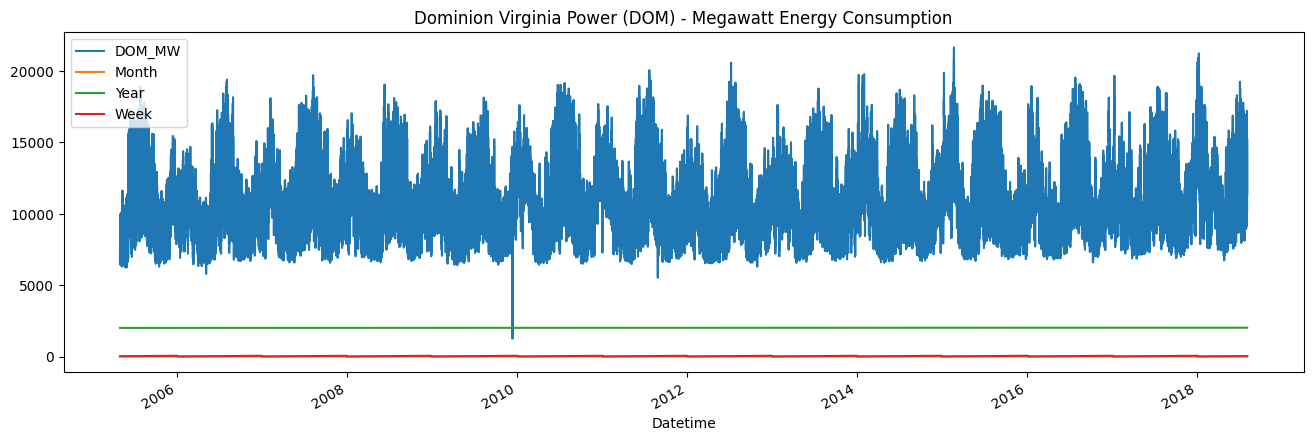

In [ ]:
df.plot(figsize=(16,5),legend=True)
plt.axhspan(0, 1, facecolor='gray', alpha=0.3)

plt.title('Dominion Virginia Power (DOM) - Megawatt Energy Consumption')

plt.show()

# Normalization Process

In [ ]:
def normalize_data(df):
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(df['DOM_MW'].values.reshape(-1,1))
    df['DOM_MW'] = normalized_data
    return df, scaler

df_norm, scaler = normalize_data(df)
df_norm.shape

(116189, 7)

In [ ]:
df_norm

,DOM_MW,Month,Year,Date,Time,Week,Day
Datetime,,,,,,,
2005-12-31 01:00:00,0.398863,12,2005,2005-12-31,01:00:00,52,Saturday
2005-12-31 02:00:00,0.383224,12,2005,2005-12-31,02:00:00,52,Saturday
2005-12-31 03:00:00,0.379841,12,2005,2005-12-31,03:00:00,52,Saturday
2005-12-31 04:00:00,0.381851,12,2005,2005-12-31,04:00:00,52,Saturday
2005-12-31 05:00:00,0.386263,12,2005,2005-12-31,05:00:00,52,Saturday
...,...,...,...,...,...,...,...
2018-01-01 20:00:00,0.841504,1,2018,2018-01-01,20:00:00,1,Monday
2018-01-01 21:00:00,0.848809,1,2018,2018-01-01,21:00:00,1,Monday
2018-01-01 22:00:00,0.836062,1,2018,2018-01-01,22:00:00,1,Monday


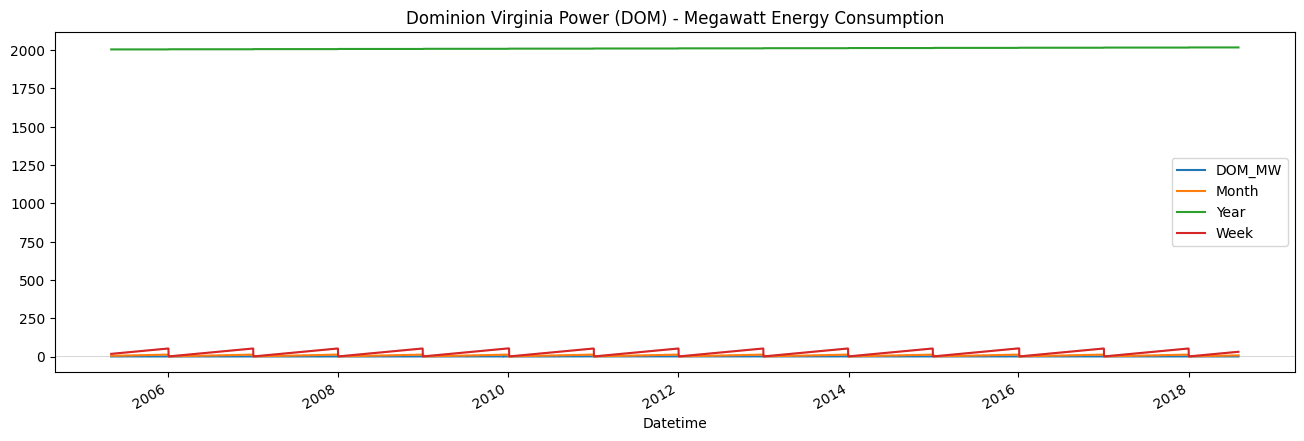

In [ ]:
# Now after normalization we can observe that the data range on y-axis is 0.0 - 1.0

df.plot(figsize=(16,5),legend=True)
plt.axhspan(0, 1, facecolor='gray', alpha=0.3)

plt.title('Dominion Virginia Power (DOM) - Megawatt Energy Consumption')

plt.show()

### Let's observe train and test data on the graph

In [ ]:
# 2017-02-13 after this date we will choose the test set
split_date = '2017-02-13'

DOM_train = df_norm.loc[df_norm.index <= split_date].copy()
DOM_test = df_norm.loc[df_norm.index > split_date].copy()

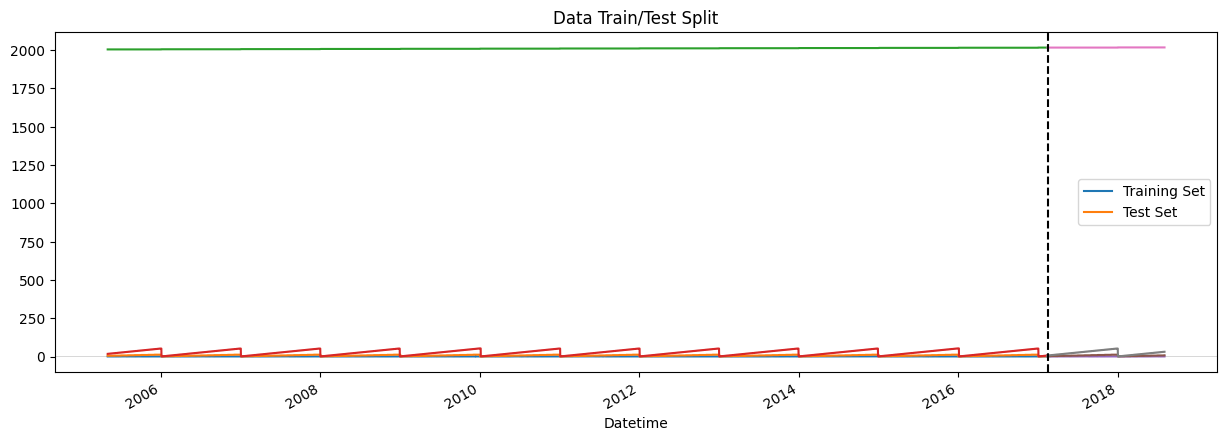

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
DOM_train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
DOM_test.plot(ax=ax, label='Test Set')
ax.axvline('2017-02-13', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.axhspan(0, 1, facecolor='gray', alpha=0.3)
plt.show()

# Prepare Data for Training the RNN & LSTM

* With the following function block, let's set our data set as training and test data set in a model appropriate way

In [ ]:
def load_data(data, seq_len):
    X_train = []
    y_train = []

    for i in range(seq_len, len(data)):
        X_train.append(data.iloc[i-seq_len : i, 0])
        y_train.append(data.iloc[i, 0])

    # last 6189 days are going to be used in test
    X_test = X_train[110000:]
    y_test = y_train[110000:]

    # first 110000 days are going to be used in training
    X_train = X_train[:110000]
    y_train = y_train[:110000]

    # convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # reshape data to input into RNN&LSTM models
    X_train = np.reshape(X_train, (110000, seq_len, 1))

    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))

    return [X_train, y_train, X_test, y_test]

* **The seq_len** parameter determines how far back the model will look at historical data, helping the model to capture time dependencies in a memory-aware way.
* We should note that if "seq_len" is too large, the model can become complex and prone to overlearning.
* We can specify separate seq_len values for RNN and LSTM

In [ ]:
seq_len = 20

# Let's create train, test data
X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (110000, 20, 1)
y_train.shape =  (110000,)
X_test.shape =  (6169, 20, 1)
y_test.shape =  (6169,)


# Build a RNN model

In [ ]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 20, 40)            1680      
                                                                 
 dropout (Dropout)           (None, 20, 40)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20, 40)            3240      
                                                                 
 dropout_1 (Dropout)         (None, 20, 40)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dropout_2 (Dropout)         (None, 40)                0         
                                                                 
 dense (Dense)               (None, 1)                 4

In [ ]:
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
110/110 [==============================] - 12s 87ms/step - loss: 0.1686
Epoch 2/10
110/110 [==============================] - 8s 75ms/step - loss: 0.0390
Epoch 3/10
110/110 [==============================] - 9s 85ms/step - loss: 0.0179
Epoch 4/10
110/110 [==============================] - 10s 88ms/step - loss: 0.0114
Epoch 5/10
110/110 [==============================] - 8s 74ms/step - loss: 0.0084
Epoch 6/10
110/110 [==============================] - 10s 87ms/step - loss: 0.0067
Epoch 7/10
110/110 [==============================] - 10s 87ms/step - loss: 0.0056
Epoch 8/10
110/110 [==============================] - 8s 74ms/step - loss: 0.0048
Epoch 9/10
110/110 [==============================] - 10s 86ms/step - loss: 0.0043
Epoch 10/10
110/110 [==============================] - 10s 88ms/step - loss: 0.0038


In [ ]:
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

193/193 [==============================] - 1s 4ms/step
R2 Score of RNN model =  0.9364168843751671


In [ ]:
# Reverse transform scaler to convert to real values
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
rnn_predictions_inverse = scaler.inverse_transform(rnn_predictions)

# Get values after inverse transformation
y_test_inverse = y_test_inverse.flatten()
rnn_predictions_inverse = rnn_predictions_inverse.flatten()

In [ ]:
last_6169_index_dates = df.index[-6169:]

# Now let's see our actual y and predicted y values as dataframes
results_RNN = pd.DataFrame({"Date":last_6169_index_dates, 'Actual': y_test_inverse, 'Predicted': rnn_predictions_inverse})
results_RNN

,Date,Actual,Predicted
0,2017-02-13 23:00:00,11494.0,11294.640625
1,2017-02-14 00:00:00,10975.0,10712.520508
2,2017-02-12 01:00:00,8728.0,10331.149414
3,2017-02-12 02:00:00,8390.0,9296.152344
4,2017-02-12 03:00:00,8283.0,8972.799805
...,...,...,...
6164,2018-01-01 20:00:00,18418.0,17934.474609
6165,2018-01-01 21:00:00,18567.0,18059.777344
6166,2018-01-01 22:00:00,18307.0,18047.099609
6167,2018-01-01 23:00:00,17814.0,17662.085938


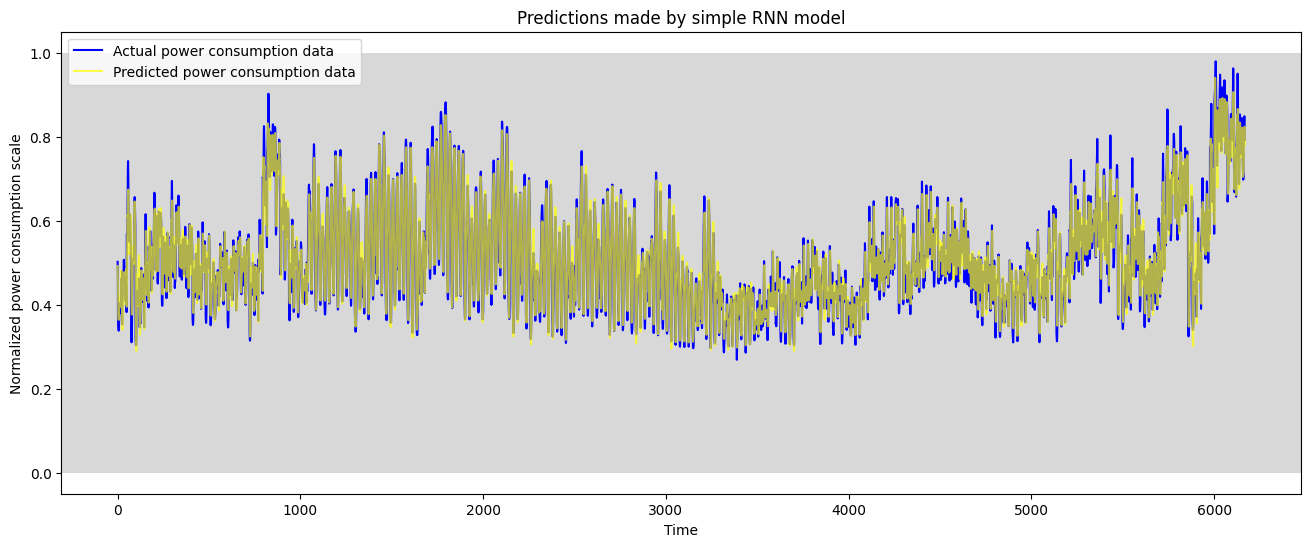

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(y_test, color='blue',label='Actual power consumption data')
plt.plot(rnn_predictions, alpha=0.7, color='yellow', label='Predicted power consumption data')
plt.axhspan(0, 1, facecolor='gray', alpha=0.3)
plt.title("Predictions made by simple RNN model")
plt.xlabel('Time')
plt.ylabel('Normalized power consumption scale')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming rnn_model, X_test, y_test, df, and scaler are already defined and available

# Make predictions on the test set
rnn_predictions = rnn_model.predict(X_test)

# Evaluate the model's R2 score
rnn_score = r2_score(y_test, rnn_predictions)
print("R2 Score of RNN model = ", rnn_score)

# Reverse transform the scaler to convert predictions to real values
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
rnn_predictions = scaler.inverse_transform(rnn_predictions)

# Get values after inverse transformation
y_test_inverse = y_test_inverse.flatten()
rnn_predictions = rnn_predictions.flatten()

# Calculate metrics
mae = mean_absolute_error(y_test_inverse, rnn_predictions)
mse = mean_squared_error(y_test_inverse, rnn_predictions)
rmse = np.sqrt(mse)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

# Visualize actual vs predicted values
last_6169_index_dates = df.index[-6169:]
results_RNN = pd.DataFrame({"Date": last_6169_index_dates, 'Actual': y_test_inverse, 'Predicted': rnn_predictions})


# Future forecasting function
def forecast_future(model, X_input, n_future_steps, scaler):

    future_predictions = []
    X_current = X_input

    for _ in range(n_future_steps):
        # Predict next value
        pred = model.predict(X_current)
        future_predictions.append(pred[0])

        # Update the input for the next prediction
        # Reshape pred to match the dimensions of X_current[:, 1:, :]
        pred = pred.reshape(X_current[:, 1:, :].shape[0], 1, X_current.shape[2])
        X_current = np.concatenate((X_current[:, 1:, :], pred), axis=1)

    # Reverse transform predictions to original scale
    future_predictions = scaler.inverse_transform(np.array(future_predictions))

    return future_predictions

# Forecast future values
n_future_steps = 65  # Number of future steps (1 year for daily data)
X_input = X_test[-1:]  # Use the last available input for future forecasting
future_predictions = forecast_future(rnn_model, X_input, n_future_steps, scaler)

# Create a date range for future predictions
last_date = df.index[-1]
# Use inclusive='right' instead of closed='right'
future_dates = pd.date_range(last_date, periods=n_future_steps + 1, inclusive='right')

# Store future dates and predictions in a DataFrame
future_forecast_df = pd.DataFrame({"Date": future_dates, "Future_Predicted": future_predictions.flatten()})
# Print the future predictions along with dates as a table (DataFrame)
print(future_forecast_df)

193/193 [==============================] - 1s 4ms/step
R2 Score of RNN model =  0.9364168843751671
MAE: 449.89509654497283
MSE: 400846.7863233319
RMSE: 633.1246214793197
1/1 [==============================] - 0s 22ms/step
         Date  Future_Predicted
0  2018-01-03      17167.595703
1  2018-01-04      16749.121094
2  2018-01-05      16439.046875
3  2018-01-06      16301.087891
4  2018-01-07      16298.279297
..        ...               ...
60 2018-03-04      14824.452148
61 2018-03-05      14851.519531
62 2018-03-06      14933.777344
63 2018-03-07      15049.646484
64 2018-03-08      15171.317383

[65 rows x 2 columns]


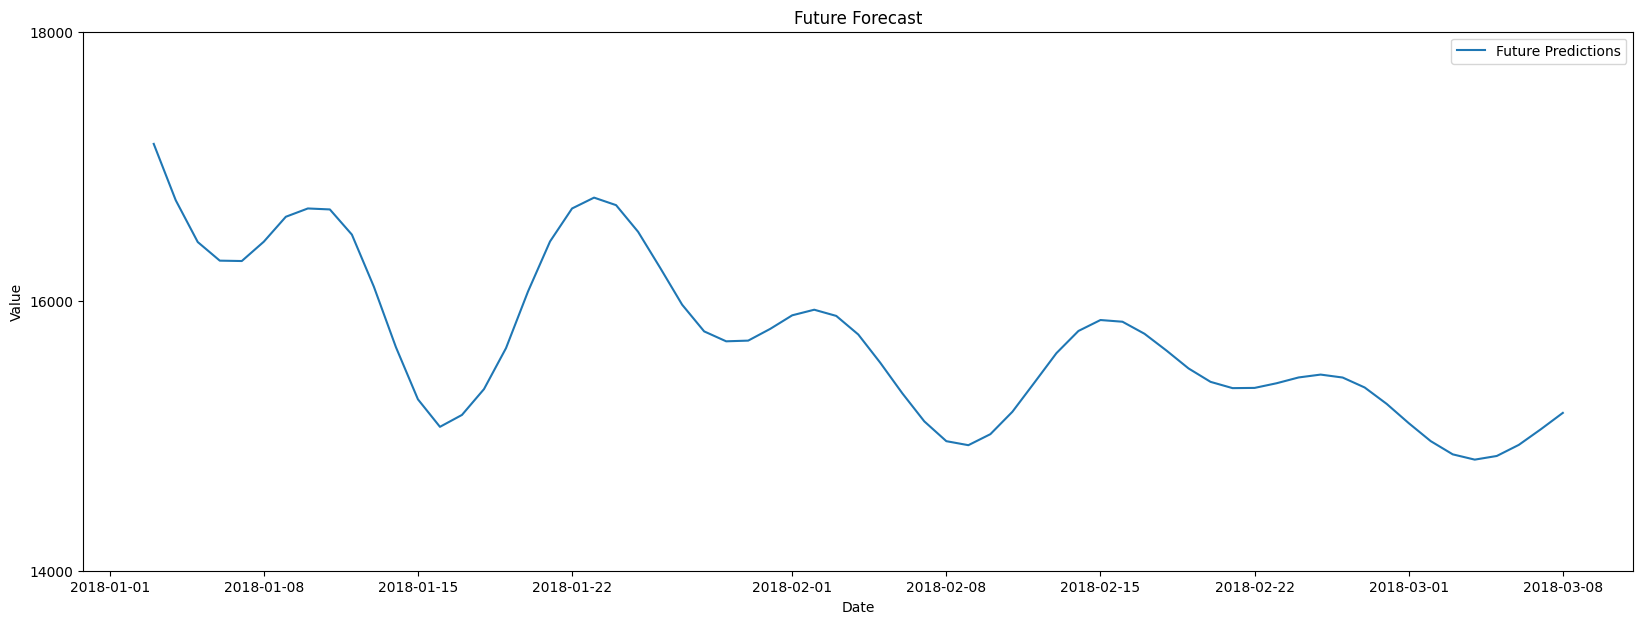

In [ ]:
plt.figure(figsize=(20,7))  # Increase the figure width to elongate the x-axis
plt.plot(future_forecast_df['Date'], future_forecast_df['Future_Predicted'], label='Future Predictions')
plt.legend()
plt.title('Future Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
# Set y-ticks in steps of 3000
y_min = future_forecast_df['Future_Predicted'].min()
y_max = future_forecast_df['Future_Predicted'].max()
plt.yticks(np.arange(y_min - (y_min % 2000), y_max + 2000, 2000))
plt.show()

# Build an LSTM model

In [ ]:
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 40)            6720      
                                                                 
 dropout_3 (Dropout)         (None, 20, 40)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 40)            12960     
                                                                 
 dropout_4 (Dropout)         (None, 20, 40)            0         
                                                                 
 lstm_2 (LSTM)               (None, 40)                12960     
                                                                 
 dropout_5 (Dropout)         (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [ ]:
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
110/110 [==============================] - 31s 241ms/step - loss: 0.0198
Epoch 2/10
110/110 [==============================] - 24s 220ms/step - loss: 0.0122
Epoch 3/10
110/110 [==============================] - 24s 220ms/step - loss: 0.0103
Epoch 4/10
110/110 [==============================] - 23s 214ms/step - loss: 0.0059
Epoch 5/10
110/110 [==============================] - 23s 213ms/step - loss: 0.0045
Epoch 6/10
110/110 [==============================] - 24s 220ms/step - loss: 0.0036
Epoch 7/10
110/110 [==============================] - 24s 219ms/step - loss: 0.0030
Epoch 8/10
110/110 [==============================] - 24s 220ms/step - loss: 0.0025
Epoch 9/10
110/110 [==============================] - 23s 209ms/step - loss: 0.0021
Epoch 10/10
110/110 [==============================] - 24s 221ms/step - loss: 0.0019


In [ ]:
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

193/193 [==============================] - 3s 8ms/step
R^2 Score of LSTM model =  0.9343073434165337


In [ ]:
# Reverse transform scaler to convert to real values
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
lstm_predictions_inverse = scaler.inverse_transform(lstm_predictions)

# Get values after inverse transformation
y_test_inverse = y_test_inverse.flatten()
lstm_predictions_inverse = lstm_predictions_inverse.flatten()

In [ ]:
# Now let's see our actual y and predicted y values as dataframes
results_LSTM = pd.DataFrame({"Date":last_6169_index_dates, 'Actual': y_test_inverse, 'Predicted': lstm_predictions_inverse})
results_LSTM

,Date,Actual,Predicted
0,2017-02-13 23:00:00,11494.0,11536.866211
1,2017-02-14 00:00:00,10975.0,10910.155273
2,2017-02-12 01:00:00,8728.0,10424.098633
3,2017-02-12 02:00:00,8390.0,8755.955078
4,2017-02-12 03:00:00,8283.0,7999.964355
...,...,...,...
6164,2018-01-01 20:00:00,18418.0,18188.349609
6165,2018-01-01 21:00:00,18567.0,17850.273438
6166,2018-01-01 22:00:00,18307.0,17735.548828
6167,2018-01-01 23:00:00,17814.0,17427.257812


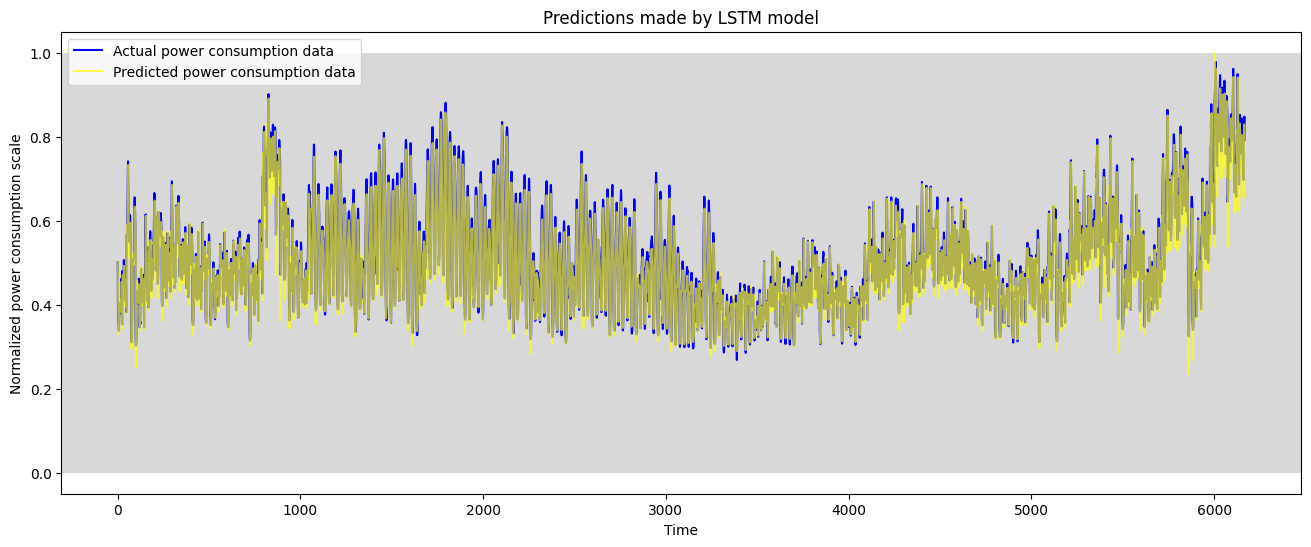

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(y_test, color='blue',label='Actual power consumption data')
plt.plot(lstm_predictions, alpha=0.7, color='yellow', label='Predicted power consumption data')
plt.axhspan(0, 1, facecolor='gray', alpha=0.3)
plt.title("Predictions made by LSTM model")
plt.xlabel('Time')
plt.ylabel('Normalized power consumption scale')
plt.legend()
plt.show()

193/193 [==============================] - 2s 8ms/step
R^2 Score of LSTM model =  0.9343073434165337
RMSE: 633.1246214793197
                    Date   Actual     Predicted
0    2017-02-13 23:00:00  11494.0  11536.866211
1    2017-02-14 00:00:00  10975.0  10910.155273
2    2017-02-12 01:00:00   8728.0  10424.098633
3    2017-02-12 02:00:00   8390.0   8755.955078
4    2017-02-12 03:00:00   8283.0   7999.964355
...                  ...      ...           ...
6164 2018-01-01 20:00:00  18418.0  18188.349609
6165 2018-01-01 21:00:00  18567.0  17850.273438
6166 2018-01-01 22:00:00  18307.0  17735.548828
6167 2018-01-01 23:00:00  17814.0  17427.257812
6168 2018-01-02 00:00:00  17428.0  16824.605469

[6169 rows x 3 columns]
1/1 [==============================] - 0s 23ms/step


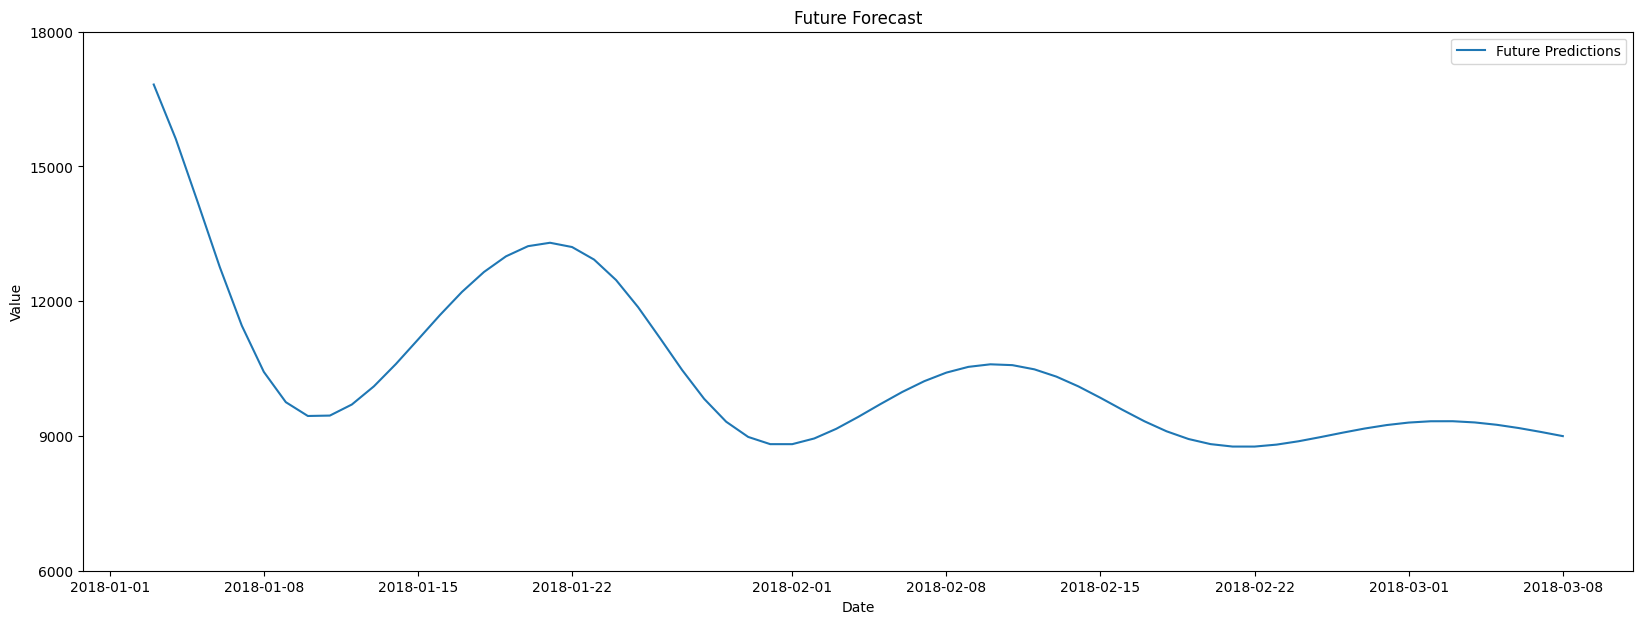

         Date  Future_Predicted
0  2018-01-03      16824.605469
1  2018-01-04      15615.361328
2  2018-01-05      14202.062500
3  2018-01-06      12760.477539
4  2018-01-07      11456.785156
..        ...               ...
60 2018-03-04       9301.306641
61 2018-03-05       9249.076172
62 2018-03-06       9176.479492
63 2018-03-07       9089.902344
64 2018-03-08       8996.688477

[65 rows x 2 columns]


In [ ]:
lstm_predictions = lstm_model.predict(X_test)

# Evaluate the model's R2 score
lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ", lstm_score)

# Reverse transform the scaler to convert predictions to real values
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
lstm_predictions_inverse = scaler.inverse_transform(lstm_predictions)

# Get values after inverse transformation
y_test_inverse = y_test_inverse.flatten()
lstm_predictions_inverse = lstm_predictions_inverse.flatten()
# Calculate metrics

rmse = np.sqrt(mse)


print(f"RMSE: {rmse}")

# Now let's see our actual y and predicted y values as dataframes
results_LSTM = pd.DataFrame({"Date": last_6169_index_dates, 'Actual': y_test_inverse, 'Predicted': lstm_predictions_inverse})
print(results_LSTM)

# Future forecasting function
def forecast_future(model, X_input, n_future_steps, scaler):
    """
    Forecast future values using the LSTM model.

    Parameters:
    - model: Trained LSTM model
    - X_input: Initial input data for prediction
    - n_future_steps: Number of future steps to predict
    - scaler: Scaler used for inverse transformation

    Returns:
    - future_predictions: Future predicted values in original scale
    """
    future_predictions = []
    X_current = X_input

    for _ in range(n_future_steps):
        # Predict next value
        pred = model.predict(X_current)
        future_predictions.append(pred[0])

        # Update the input for the next prediction
        # Reshape pred to match the dimensions of X_current[:, 1:, :]
        pred = pred.reshape(X_current[:, 1:, :].shape[0], 1, X_current.shape[2])
        X_current = np.concatenate((X_current[:, 1:, :], pred), axis=1)

    # Reverse transform predictions to original scale
    future_predictions = scaler.inverse_transform(np.array(future_predictions))

    return future_predictions

# Forecast future values
n_future_steps = 65  # Number of future steps (1 year for daily data)
X_input = X_test[-1:]  # Use the last available input for future forecasting
future_predictions = forecast_future(lstm_model, X_input, n_future_steps, scaler)

# Create a date range for future predictions
last_date = df.index[-1]
# Use inclusive='right' instead of closed='right'
future_dates = pd.date_range(last_date, periods=n_future_steps + 1, inclusive='right')

# Store future dates and predictions in a DataFrame
future_forecast_df = pd.DataFrame({"Date": future_dates, "Future_Predicted": future_predictions.flatten()})

# Visualize future forecast with elongated x-axis and y-axis range in steps of 3000
plt.figure(figsize=(20,7))  # Increase the figure width to elongate the x-axis
plt.plot(future_forecast_df['Date'], future_forecast_df['Future_Predicted'], label='Future Predictions')
plt.legend()
plt.title('Future Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
# Set y-ticks in steps of 3000
y_min = future_forecast_df['Future_Predicted'].min()
y_max = future_forecast_df['Future_Predicted'].max()
plt.yticks(np.arange(y_min - (y_min % 3000), y_max + 3000, 3000))
plt.show()

# Print the future predictions along with dates as a table (DataFrame)
print(future_forecast_df)

# Compare Predictions

* For both models, we see that the predicted values are close to the actual values, which means that the models perform well in predicting the sequence.

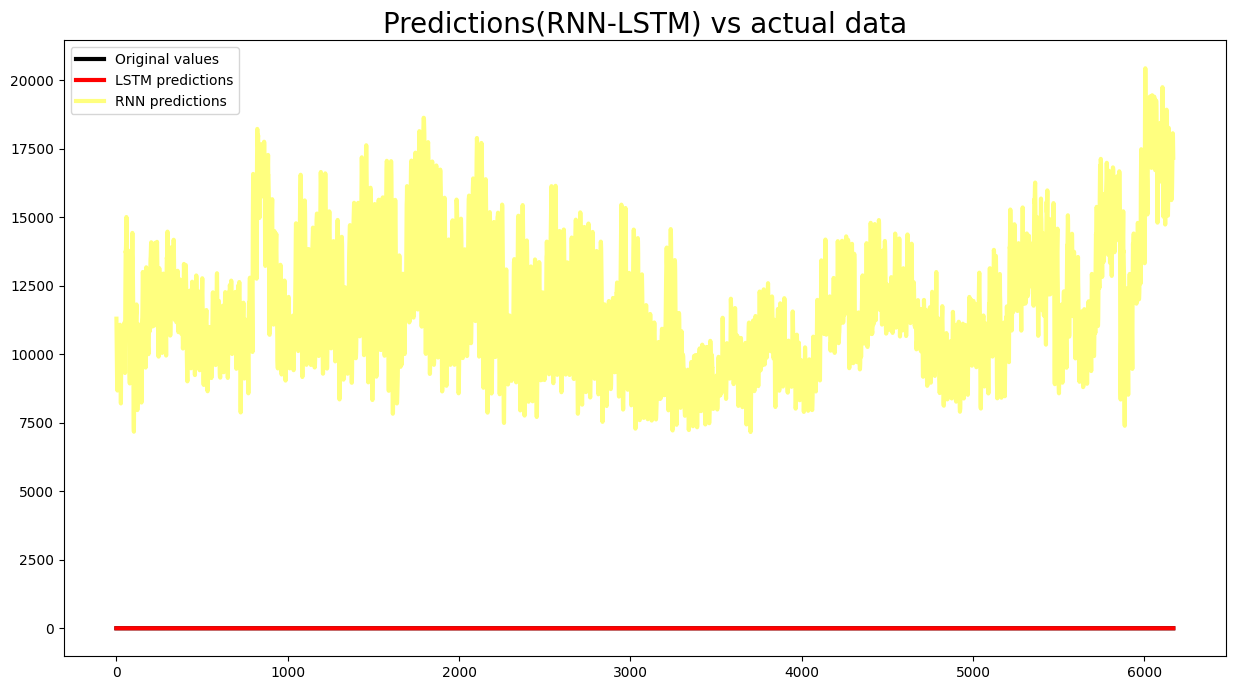

In [ ]:
plt.figure(figsize=(15,8))

plt.plot(y_test, c="black", linewidth=3, label="Original values")
plt.plot(lstm_predictions, c="red", linewidth=3, label="LSTM predictions")
plt.plot(rnn_predictions, alpha=0.5, c="yellow", linewidth=3, label="RNN predictions")
plt.axhspan(0, 1, facecolor='gray', alpha=0.3)
plt.legend()
plt.title("Predictions(RNN-LSTM) vs actual data", fontsize=20)
plt.show()

In [ ]:
# Replace 'closed' with 'inclusive' for older pandas versions
future_dates = pd.date_range(last_date, periods=n_future_steps + 1, inclusive='right')
forecast_df = pd.DataFrame({'Datetime': future_dates, 'Forecasted': future_predictions.flatten()})

print(forecast_df)

     Datetime    Forecasted
0  2018-01-03  16824.605469
1  2018-01-04  15615.361328
2  2018-01-05  14202.062500
3  2018-01-06  12760.477539
4  2018-01-07  11456.785156
..        ...           ...
60 2018-03-04   9301.306641
61 2018-03-05   9249.076172
62 2018-03-06   9176.479492
63 2018-03-07   9089.902344
64 2018-03-08   8996.688477

[65 rows x 2 columns]
